In [32]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import adjusted_rand_score, confusion_matrix

import umap
import hdbscan

In [22]:
X = np.load('Data/text_data150.npy')
y = np.load('Data/labels150.npy')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

In [ ]:
sizes = np.arange(1, 11)
dimensions = 2 ** np.arange(1, 11)
rand_scores_hdbscan = np.zeros((len(dimensions), len(sizes)))
rand_scores_kmeans = np.zeros((len(dimensions), len(sizes)))
all_labels_hdbscan = np.zeros((len(dimensions), len(sizes)), dtype=object)
all_labels_kmeans = np.zeros((len(dimensions), len(sizes)), dtype=object)

for idy, dim in enumerate(dimensions):
    print(f'Dimension: {dim}')
    for idx, size in enumerate(sizes):
        if size == 10:
            X_val, y_val = X_train, y_train
        else:
            X_t2, X_val, y_t2, y_val = train_test_split(X_train, y_train, test_size=size/10, stratify=y_train, random_state=3)

        if dim == 1024:
            embedding_train = X_train
        else:
            mapper = umap.UMAP(n_neighbors=30,
                                min_dist=0.1,
                                init='Spectral',
                                metric='euclidean',
                                n_components=dim).fit(X_val, y=y_val)
            embedding_train = mapper.transform(X_train)

        labels_hdb = hdbscan.HDBSCAN(
            min_samples=10,
            min_cluster_size=500,
        ).fit_predict(embedding_train)

        kmeans = KMeans(n_clusters=5, random_state=3)
        kmeans.fit(embedding_train)
        labels_kmeans = kmeans.labels_

        rand_scores_hdbscan[idy,idx] = adjusted_rand_score(y_train, labels_hdb)
        rand_scores_kmeans[idy, idx] = adjusted_rand_score(y_train, labels_kmeans)

        all_labels_hdbscan[idy, idx] = labels_hdb
        all_labels_kmeans[idy, idx] = labels_kmeans

Dimension: 2
Dimension: 4
Dimension: 8
Dimension: 16
Dimension: 32
Dimension: 64
Dimension: 128
Dimension: 256
Dimension: 512


c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\spectral.py:519: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(


TypeError: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.

In [45]:
all_labels_hdbscan

array([[array([2, 1, 0, ..., 0, 2, 1], dtype=int64),
        array([2, 3, 0, ..., 0, 2, 3], dtype=int64),
        array([0, 3, 1, ..., 1, 0, 3], dtype=int64),
        array([4, 3, 0, ..., 0, 4, 3], dtype=int64),
        array([2, 3, 1, ..., 1, 2, 3], dtype=int64),
        array([3, 4, 2, ..., 2, 3, 4], dtype=int64),
        array([1, 4, 3, ..., 3, 1, 4], dtype=int64),
        array([3, 2, 1, ..., 1, 3, 2], dtype=int64),
        array([1, 2, 4, ..., 4, 1, 2], dtype=int64),
        array([0, 4, 2, ..., 2, 0, 4], dtype=int64)],
       [array([2, 4, 1, ..., 1, 2, 4], dtype=int64),
        array([0, 3, 1, ..., 1, 0, 3], dtype=int64),
        array([3, 1, 0, ..., 0, 3, 1], dtype=int64),
        array([2, 4, 0, ..., 0, 2, 4], dtype=int64),
        array([3, 2, 1, ..., 1, 3, 2], dtype=int64),
        array([1, 2, 0, ..., 0, 1, 2], dtype=int64),
        array([4, 2, 0, ..., 0, 4, 2], dtype=int64),
        array([1, 3, 0, ..., 0, 1, 3], dtype=int64),
        array([2, 3, 1, ..., 1, 2, 3], dtype=

In [33]:
confusion_matrix(y_train, all_labels_hdbscan[0, 0])

array([[   0,    0,    0,    0,    0,    0],
       [   9,    0,    0,  644,    0,    0],
       [  29,    0,    0,    2,   20, 1029],
       [   1,  866,    0,    0,    0,    0],
       [  34,    1,    1,    0, 1023,    2],
       [   9,    1, 1061,    0,    0,    2]], dtype=int64)

In [22]:
rand_scores_kmeans

array([0.97058958, 0.97301281, 0.97317593, 0.97419671, 0.97591529,
       0.97694014, 0.98040987, 0.98184232, 0.98832843, 0.        ,
       0.        ])

### Component reduction

In [2]:
X = np.load('Data/text_data150.npy')
y = np.load('Data/labels150.npy')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

In [7]:
size_reduction = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
rand_scores_hdbscan = np.zeros((10, 2))
rand_scores_kmeans = np.zeros((10, 2))

for idx, size in enumerate(size_reduction):
    mapper = umap.UMAP(n_neighbors=30,
                        min_dist=0.0,
                        n_components=size,
                        random_state=3).fit(X_train)
    embedding_train = mapper.transform(X_train)

    pca = PCA(n_components=size)
    pca_reduced = pca.fit_transform(X_train)

    for idy, dim_red in enumerate([embedding_train, pca_reduced]):
        labels_hdb = hdbscan.HDBSCAN(
            min_samples=10,
            min_cluster_size=500,
        ).fit_predict(dim_red)

        kmeans = KMeans(n_clusters=5, random_state=3)
        kmeans.fit(dim_red)
        labels_kmeans = kmeans.labels_

        rand_scores_hdbscan[idx, idy] = adjusted_rand_score(y_train, labels_hdb)
        rand_scores_kmeans[idx, idy] = adjusted_rand_score(y_train, labels_kmeans)

c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\umap_

In [8]:
rand_scores_kmeans

array([[0.97808185, 0.63946648],
       [0.97849662, 0.92851325],
       [0.97846158, 0.9441771 ],
       [0.9802007 , 0.94995422],
       [0.9773438 , 0.95175034],
       [0.97732601, 0.95221702],
       [0.97846158, 0.95302322],
       [0.97963203, 0.95255901],
       [0.97847828, 0.95255901],
       [0.97906404, 0.95255901]])

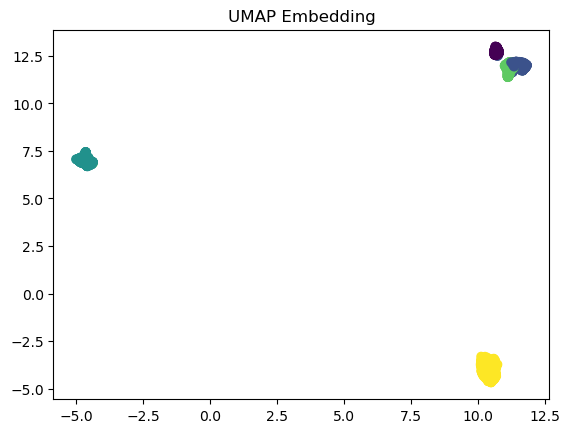

In [9]:
import matplotlib.pyplot as plt
plt.scatter(embedding_train[:, 0], embedding_train[:, 1], c=y_train)
plt.title("UMAP Embedding")
plt.show()

### Component reduction Snetences

In [16]:
X = np.load('Data/text_data_sentences.npy')
y = np.load('Data/labels_sentences.npy')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

In [11]:
size_reduction = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
rand_scores_hdbscan = np.zeros((10, 2))
rand_scores_kmeans = np.zeros((10, 2))

for idx, size in enumerate(size_reduction):
    mapper = umap.UMAP(n_neighbors=30,
                        min_dist=0.0,
                        n_components=size,
                        random_state=3).fit(X_train)
    embedding_train = mapper.transform(X_train)

    pca = PCA(n_components=size)
    pca_reduced = pca.fit_transform(X_train)

    for idy, dim_red in enumerate([embedding_train, pca_reduced]):
        labels_hdb = hdbscan.HDBSCAN(
            min_samples=10,
            min_cluster_size=500,
        ).fit_predict(dim_red)

        kmeans = KMeans(n_clusters=5, random_state=3)
        kmeans.fit(dim_red)
        labels_kmeans = kmeans.labels_

        rand_scores_hdbscan[idx, idy] = adjusted_rand_score(y_train, labels_hdb)
        rand_scores_kmeans[idx, idy] = adjusted_rand_score(y_train, labels_kmeans)

c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\umap_

In [13]:
rand_scores_kmeans

array([[0.73068498, 0.45973438],
       [0.73307141, 0.58215041],
       [0.72853385, 0.5642931 ],
       [0.73049169, 0.56587364],
       [0.7296958 , 0.56177019],
       [0.73264304, 0.55990323],
       [0.72869972, 0.55849828],
       [0.73132112, 0.55941463],
       [0.73076477, 0.55964053],
       [0.73042748, 0.56041615]])

In [12]:
rand_scores_hdbscan

array([[0.43352324, 0.19526165],
       [0.43400785, 0.2009893 ],
       [0.43384648, 0.19793532],
       [0.43373761, 0.20618447],
       [0.43394928, 0.20322818],
       [0.43400641, 0.17690155],
       [0.43232947, 0.14633049],
       [0.4341643 , 0.18040815],
       [0.43305251, 0.12016146],
       [0.43371736, 0.12023362]])

In [17]:
X_train_init = X_train
y_train_init = y_train

In [19]:
sizes = np.arange(1, 11)
sizes

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [20]:
sizes = np.arange(1, 10)
rand_scores_hdbscan = np.zeros(9)
rand_scores_kmeans = np.zeros(9)

for idx, size in enumerate(sizes):
    X_train, X_val, y_train, y_val = train_test_split(X_train_init, y_train_init, test_size=size/10, stratify=y_train_init, random_state=3)

    mapper = umap.UMAP(n_neighbors=30,
                        min_dist=0.0,
                        n_components=256,
                        random_state=3).fit(X_val, y=y_val)
    embedding_train = mapper.transform(X_train)

    labels_hdb = hdbscan.HDBSCAN(
        min_samples=10,
        min_cluster_size=500,
    ).fit_predict(embedding_train)

    kmeans = KMeans(n_clusters=5, random_state=3)
    kmeans.fit(embedding_train)
    labels_kmeans = kmeans.labels_

    rand_scores_hdbscan[idx] = adjusted_rand_score(y_train, labels_hdb)
    rand_scores_kmeans[idx] = adjusted_rand_score(y_train, labels_kmeans)

c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\umap\umap_

In [21]:
rand_scores_hdbscan

array([0.62677845, 0.68586126, 0.68647737, 0.71793824, 0.71785488,
       0.65880033, 0.44606114, 0.        , 0.        ])

In [22]:
rand_scores_kmeans

array([0.68117271, 0.72757966, 0.77684112, 0.78922113, 0.74113828,
       0.70430439, 0.7150721 , 0.69123363, 0.78145788])